TODO..

- Look at 2-medioids splitting.  Estimate mean Tanimoto distance between the splits.  Compare with mean Tanimoto distance between activity-based splits.

- Run a version of the paper that does exactly the same thing, but with no activity splitting (as a benchmark).

In [1]:
from __future__ import division, print_function

import joblib
import numpy as np
from IPython.display import SVG
from scipy.spatial.distance import pdist, squareform, jaccard, cityblock
from scipy import stats

from multiprocessing import Pool
from copy import deepcopy

from sklearn.metrics import mean_squared_error, r2_score
from sklearn import linear_model as LM

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge, RidgeCV, BayesianRidge, ElasticNet, Lasso

from keras.models import Sequential
from keras.layers import Dense, Activation

from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.svm import SVR

# Deep learning model with intermediate layer...
def larger_model():
    # create model
    model = Sequential()
    model.add(Dense(128, input_dim=128, kernel_initializer='normal', activation='relu'))
    model.add(Dense(16, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasRegressor(build_fn=larger_model, epochs=100, batch_size=5, verbose=0)))

import pandas as pd


# Model dictionaries 
model_labels = ['Ridge Regression','Random Forests','Support Vector Regression','Deep Learning']
model_dict = {'ridge' : {'m' : Ridge, 'kw' : {'fit_intercept':True, 'alpha':0.1}, 'label' : model_labels[0],},
              'rf'    : {'m' : RandomForestRegressor, 'kw' : {'n_estimators':100, 
                                                              'n_jobs':4, 'max_depth':10},  'label' : model_labels[1],},
              'svr'   : {'m' : SVR, 'kw' : {}, 'label' : model_labels[2],},
              
              'dl_l'   : {'m' : Pipeline, 
                          'kw' : {'steps': [('standardize', StandardScaler()),
                                            ('mlp', KerasRegressor(build_fn=larger_model, 
                                                                   epochs=100, batch_size=5, 
                                                                   verbose=0))
                                                           ]},  'label' : model_labels[3],
                         },
             }

# Datasets
from glob import glob
targets = [s.replace('datasets/', '') for s in glob('datasets/*')]

Using TensorFlow backend.


In [2]:
# From https://github.com/letiantian/kmedoids/blob/master/kmedoids.py
# The following does k-mediods clustering on data D
def kMedoids(D, k, tmax=100):
    # determine dimensions of distance matrix D
    m, n = D.shape

    if k > n:
        raise Exception('too many medoids')

    # find a set of valid initial cluster medoid indices since we
    # can't seed different clusters with two points at the same location
    valid_medoid_inds = set(range(n))
    invalid_medoid_inds = set([])
    rs,cs = np.where(D==0)
    # the rows, cols must be shuffled because we will keep the first duplicate below
    index_shuf = range(len(rs))
    np.random.shuffle(index_shuf)
    rs = rs[index_shuf]
    cs = cs[index_shuf]
    for r,c in zip(rs,cs):
        # if there are two points with a distance of 0...
        # keep the first one for cluster init
        if r < c and r not in invalid_medoid_inds:
            invalid_medoid_inds.add(c)
    valid_medoid_inds = list(valid_medoid_inds - invalid_medoid_inds)

    if k > len(valid_medoid_inds):
        raise Exception('too many medoids (after removing {} duplicate points)'.format(
            len(invalid_medoid_inds)))

    # randomly initialize an array of k medoid indices
    M = np.array(valid_medoid_inds)
    np.random.shuffle(M)
    M = np.sort(M[:k])

    # create a copy of the array of medoid indices
    Mnew = np.copy(M)

    # initialize a dictionary to represent clusters
    C = {}
    for t in xrange(tmax):
        # determine clusters, i. e. arrays of data indices
        J = np.argmin(D[:,M], axis=1)
        for kappa in range(k):
            C[kappa] = np.where(J==kappa)[0]
        # update cluster medoids
        for kappa in range(k):
            J = np.mean(D[np.ix_(C[kappa],C[kappa])],axis=1)
            j = np.argmin(J)
            Mnew[kappa] = C[kappa][j]
        np.sort(Mnew)
        # check for convergence
        if np.array_equal(M, Mnew):
            break
        M = np.copy(Mnew)
    else:
        # final update of cluster memberships
        J = np.argmin(D[:,M], axis=1)
        for kappa in range(k):
            C[kappa] = np.where(J==kappa)[0]

            
    M = np.sort(M[:k])
    # return results
    return M, C


In [3]:
from sklearn.metrics.pairwise import pairwise_distances
import joblib

In [4]:
# Pull in data for a single target name
def get_data(tgt_name='COX-2'):
    data_dir = 'datasets/' + tgt_name + '/'
    preds = joblib.load(data_dir + tgt_name + '_predsu.npy')
    resps = joblib.load(data_dir + tgt_name + '_respu.npy')
    smiles = joblib.load(data_dir + tgt_name + '.smiu')
    dy = joblib.load(data_dir + tgt_name + '.dyu')
    return preds, resps, smiles, dy

### First let's look at the smallest dataset - A2a.

In [5]:
p, r, sm, _ = get_data('A2a')

In [6]:
p.shape

(199, 128)

In [7]:
D = pairwise_distances(np.asarray(p), metric='jaccard')

/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)


In [8]:
D.shape

(199, 199)

In [9]:
D

array([[ 0.        ,  0.66153846,  0.75      , ...,  0.73529412,
         0.72      ,  0.734375  ],
       [ 0.66153846,  0.        ,  0.79365079, ...,  0.68181818,
         0.5942029 ,  0.73846154],
       [ 0.75      ,  0.79365079,  0.        , ...,  0.75      ,
         0.71212121,  0.79310345],
       ..., 
       [ 0.73529412,  0.68181818,  0.75      , ...,  0.        ,
         0.73684211,  0.71428571],
       [ 0.72      ,  0.5942029 ,  0.71212121, ...,  0.73684211,
         0.        ,  0.66176471],
       [ 0.734375  ,  0.73846154,  0.79310345, ...,  0.71428571,
         0.66176471,  0.        ]])

In [10]:
p.shape[0]
center1 = np.zeros(5000) 

for i in xrange(5000):
    M, C = kMedoids(D, 2)
    center1[i] = M[0]
    

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import figure
figure(num=None, figsize=(10, 8), dpi=300, facecolor='w', edgecolor='k')

plt.hist(center1)


(array([  1.57100000e+03,   5.60000000e+01,   2.01000000e+02,
          1.00000000e+00,   4.20000000e+01,   2.99400000e+03,
          0.00000000e+00,   6.40000000e+01,   4.00000000e+01,
          3.10000000e+01]),
 array([   1. ,   19.8,   38.6,   57.4,   76.2,   95. ,  113.8,  132.6,
         151.4,  170.2,  189. ]),
 <a list of 10 Patch objects>)

In [12]:
from scipy.spatial.distance import pdist

In [13]:
# distance between the two clusters...
print('Distance between cluster centres: {:.4f}'.format(pairwise_distances(p[M[0]].reshape(1,-1), 
                                                                p[M[1]].reshape(1,-1), 
                                                                metric='jaccard')[0,0]))

# average pairwise distance 
Global_pw_distance = pdist(p, metric='jaccard')
print('Average pairwise distance:        {:.4f}'.format(np.median(Global_pw_distance)))

# average pairwise distance in clusters...
C0_pw_distance = pdist(p[C[0]], metric='jaccard')
print('Average pairwise distance (C0):   {:.4f}'.format(np.median(C0_pw_distance)))
C1_pw_distance = pdist(p[C[1]], metric='jaccard')
print('Average pairwise distance (C1):   {:.4f}'.format(np.median(C1_pw_distance)))
# if you split half-way by activity...
idcs = np.argsort(r)
idx_end = int(r.shape[0]/2)

C0A_pw_distance = pdist(p[idcs[:idx_end]], metric='jaccard')
C1A_pw_distance = pdist(p[idcs[idx_end:]], metric='jaccard')

print('Average pairwise distance (C0A):  {:.4f}'.format(np.median(C0A_pw_distance)))
print('Average pairwise distance (C1A):  {:.4f}'.format(np.median(C1A_pw_distance)))



Distance between cluster centres: 0.7051
Average pairwise distance:        0.7385
Average pairwise distance (C0):   0.7188
Average pairwise distance (C1):   0.7313
Average pairwise distance (C0A):  0.7619
Average pairwise distance (C1A):  0.7105


In [14]:
figure(num=None, figsize=(10, 8), dpi=300, facecolor='w', edgecolor='k')
sns.distplot(Global_pw_distance, hist = False, kde = True,
             kde_kws = { "color" : 'k', "lw" : 1}, label='Global')
sns.distplot(C0_pw_distance, hist = False, kde = True,
             kde_kws = {"color" : 'r', "lw" : 2, 'linestyle':'--'}, 
             label='Similarity Cluster 1')
sns.distplot(C1_pw_distance, color='r--', hist = False, kde = True,
             kde_kws = {"color" : 'r', "lw" : 2, 'linestyle':'-'}, 
             label='Similarity Cluster 2')
sns.distplot(C0A_pw_distance, color='b-', hist = False, kde = True,
             kde_kws = {'linewidth': 3}, label='Activity Cluster 1')

sns.distplot(C1A_pw_distance, color='b--', hist = False, kde = True,
             kde_kws = {'linewidth': 3}, label='Activity Cluster 2')
#path = 'figures/'+ 'A2a' + '_' + 'ClusterSimilarity' + '.png'
#plt.savefig(path, dpi=400)

Error in callback <function post_execute at 0x1a1444ba28> (for post_execute):


ValueError: Invalid RGBA argument: 'b-'

ValueError: Invalid RGBA argument: 'b-'

<Figure size 3000x2400 with 1 Axes>

### Now let's do it for everything...

In [15]:
from glob import glob
targets = [s.replace('datasets/', '') for s in glob('datasets/*')]
sorted_targets = sorted(targets, key=lambda x: len(get_data(x)[0]))

In [16]:
results = {'name' : [], 'CentroidCentroid' : [],
           'SimCluster1_within' : [], 'SimCluster2_within' : [], 
           'ActivityCluster1_within' : [], 'ActivityCluster2_within' :[]}

for tgt in sorted_targets:
    results['name'].append(tgt)
    p, r, s, _ = get_data(tgt)
    D = pairwise_distances(np.asarray(p), metric='jaccard')
    Nruns = 1
    
    Global_pw_dist = np.median(pdist(p, metric='jaccard'))
    idcs = np.argsort(r)
    idx_end = int(r.shape[0]* 0.9)    
    ActivityCluster1_dist = np.median(pdist(p[idcs[:idx_end]], metric='jaccard'))/Global_pw_dist
    ActivityCluster2_dist = np.median(pdist(p[idcs[idx_end:]], metric='jaccard'))/Global_pw_dist     
    
    
    M, C = kMedoids(D, 2)
    CentroidCentroid_dist = pairwise_distances(p[M[0]].reshape(1,-1), 
                                               p[M[1]].reshape(1,-1), metric='jaccard')[0,0]
    CentroidCentroid_dist = CentroidCentroid_dist/Global_pw_dist
    SimCluster1_dist = np.median(pdist(p[C[0]], metric='jaccard'))/Global_pw_dist
    SimCluster2_dist = np.median(pdist(p[C[1]], metric='jaccard'))/Global_pw_dist 
                 
    results['CentroidCentroid'].append(CentroidCentroid_dist)
    results['SimCluster1_within'].append(SimCluster1_dist)
    results['SimCluster2_within'].append(SimCluster2_dist)
    results['ActivityCluster1_within'].append(ActivityCluster1_dist)
    results['ActivityCluster2_within'].append(ActivityCluster2_dist)

In [17]:
print(np.median(pdist(p[C[0]], metric='jaccard')))
print(np.median(pdist(p[C[1]], metric='jaccard')))

0.684931506849
0.694444444444


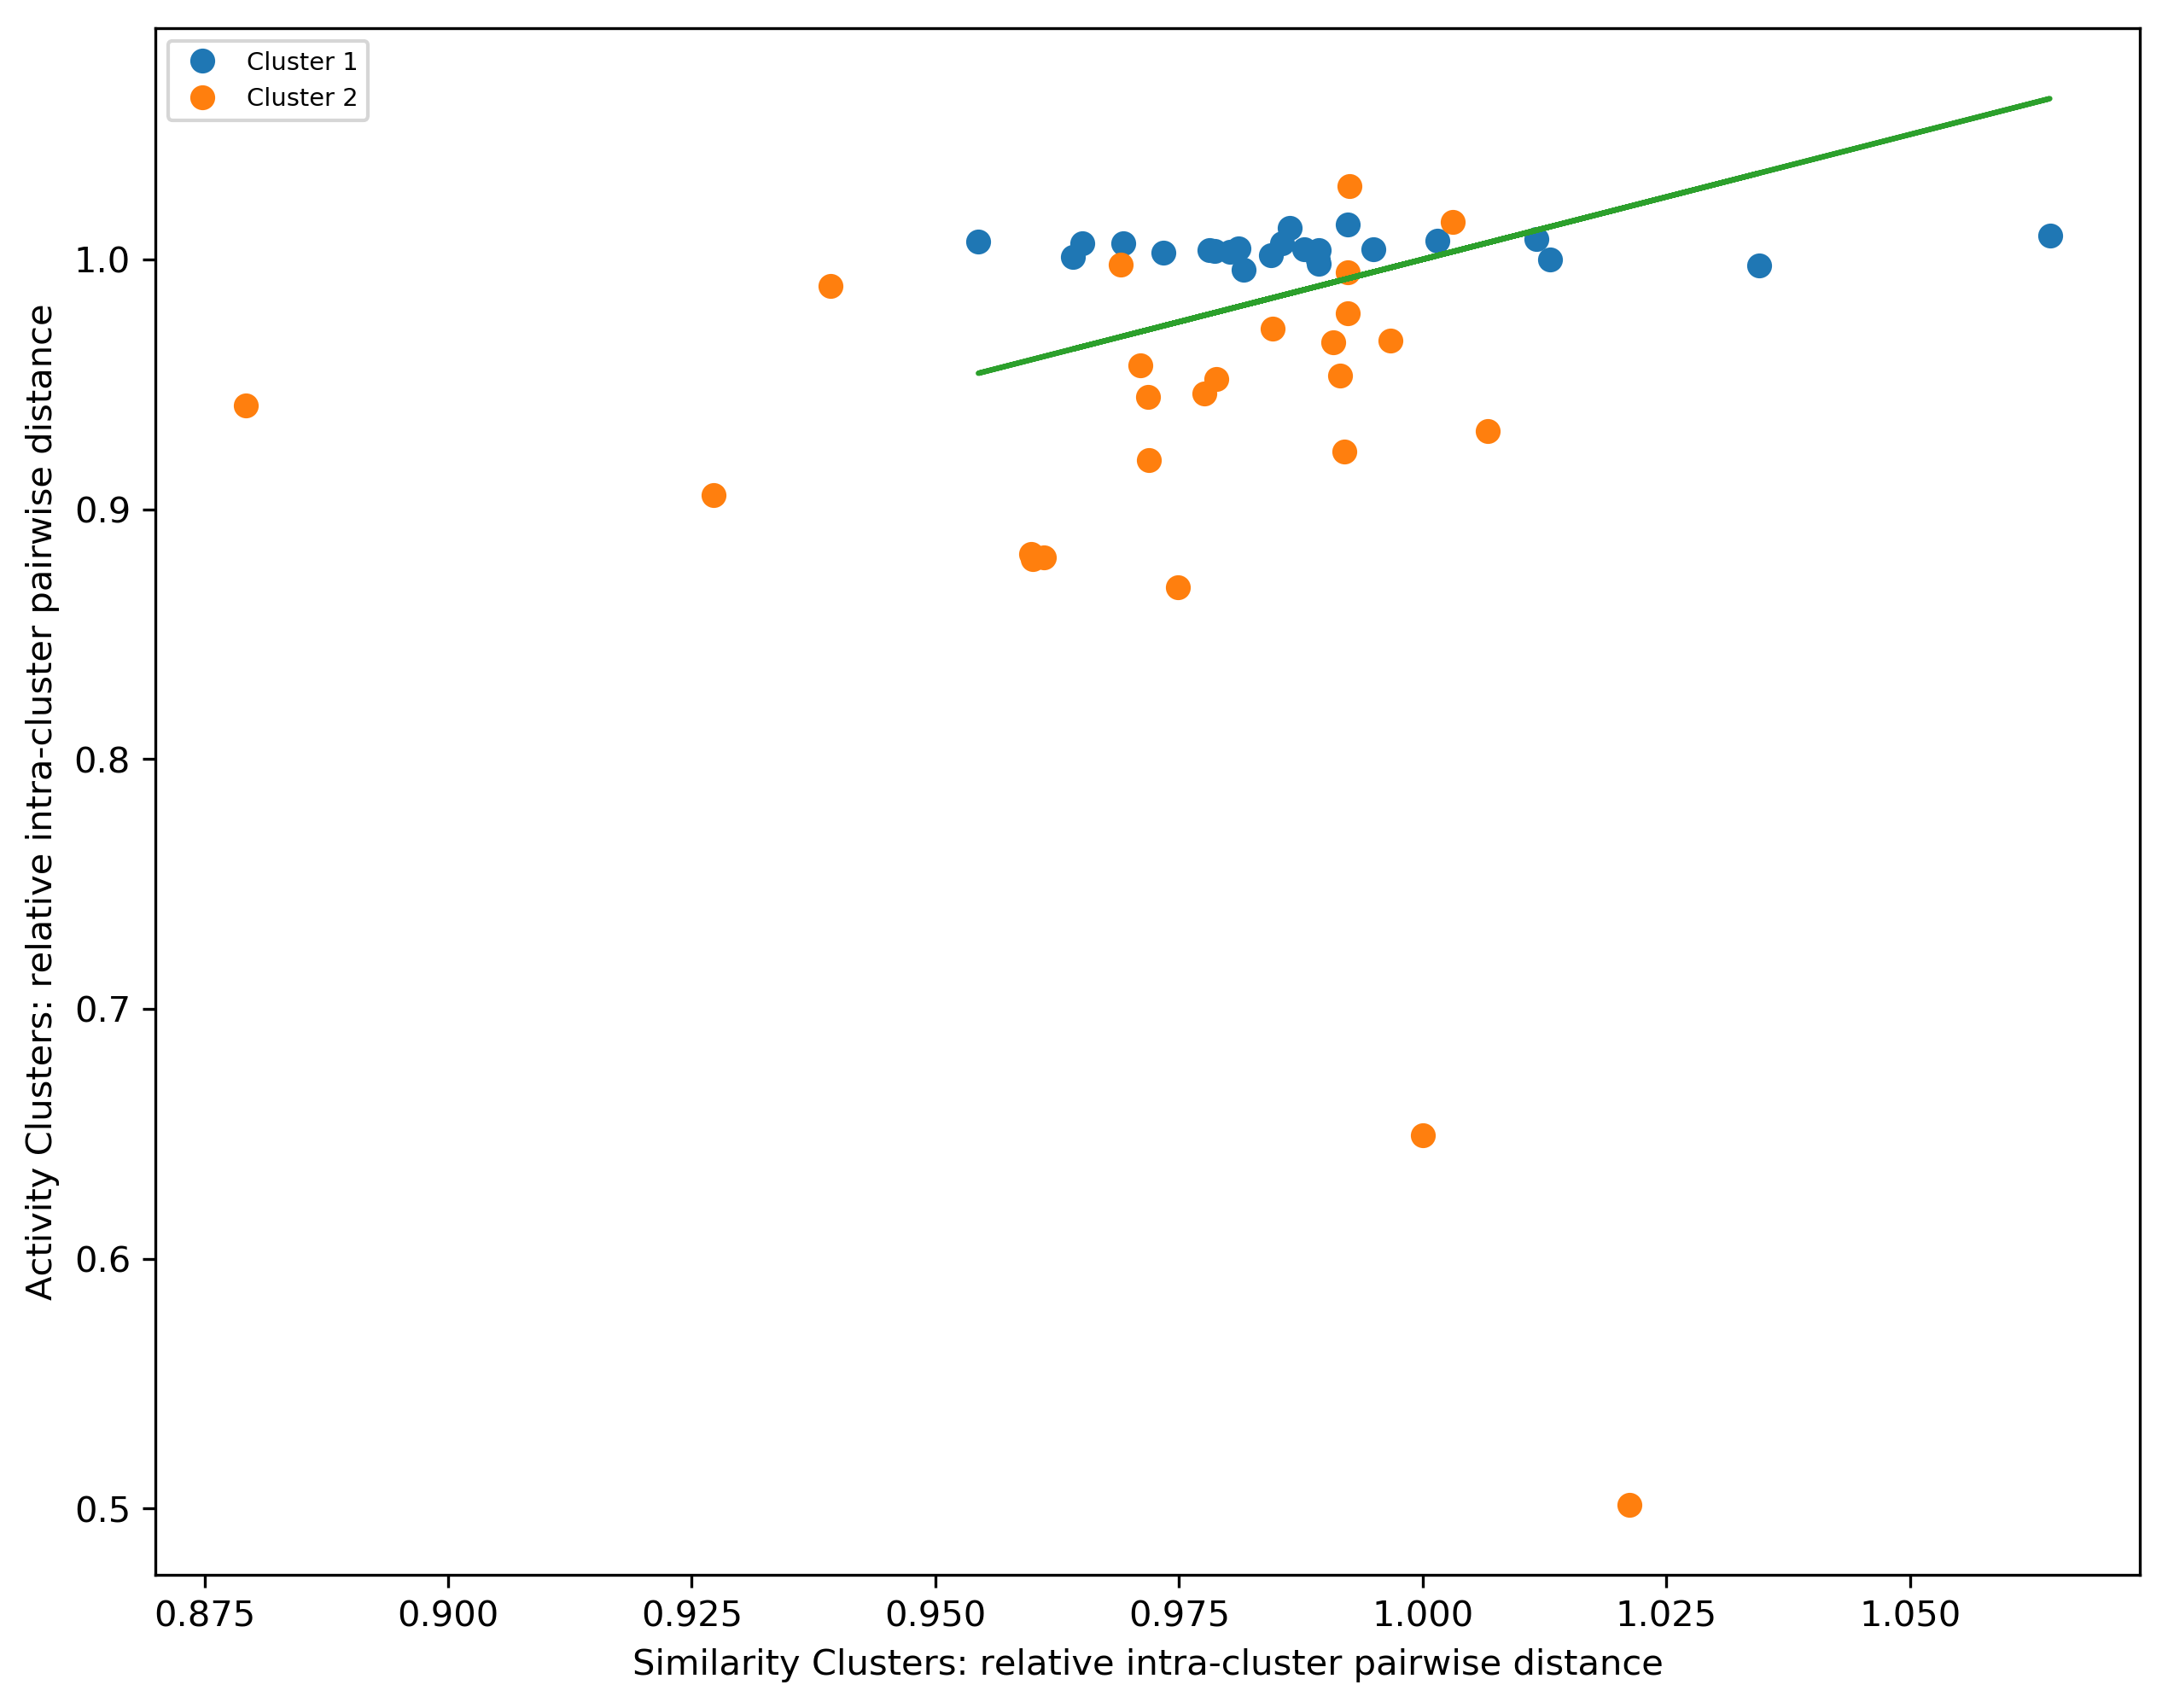

In [18]:
figure(num=None, figsize=(10, 8), dpi=300, facecolor='w', edgecolor='k')
plt.plot(results['SimCluster1_within'], results['ActivityCluster1_within'],'o',label='Cluster 1')
plt.plot(results['SimCluster2_within'], results['ActivityCluster2_within'],'o',label='Cluster 2')
plt.plot(results['SimCluster1_within'], results['SimCluster1_within'])
plt.xlabel('Similarity Clusters: relative intra-cluster pairwise distance')
plt.ylabel('Activity Clusters: relative intra-cluster pairwise distance')
plt.legend(fontsize = 'x-small')

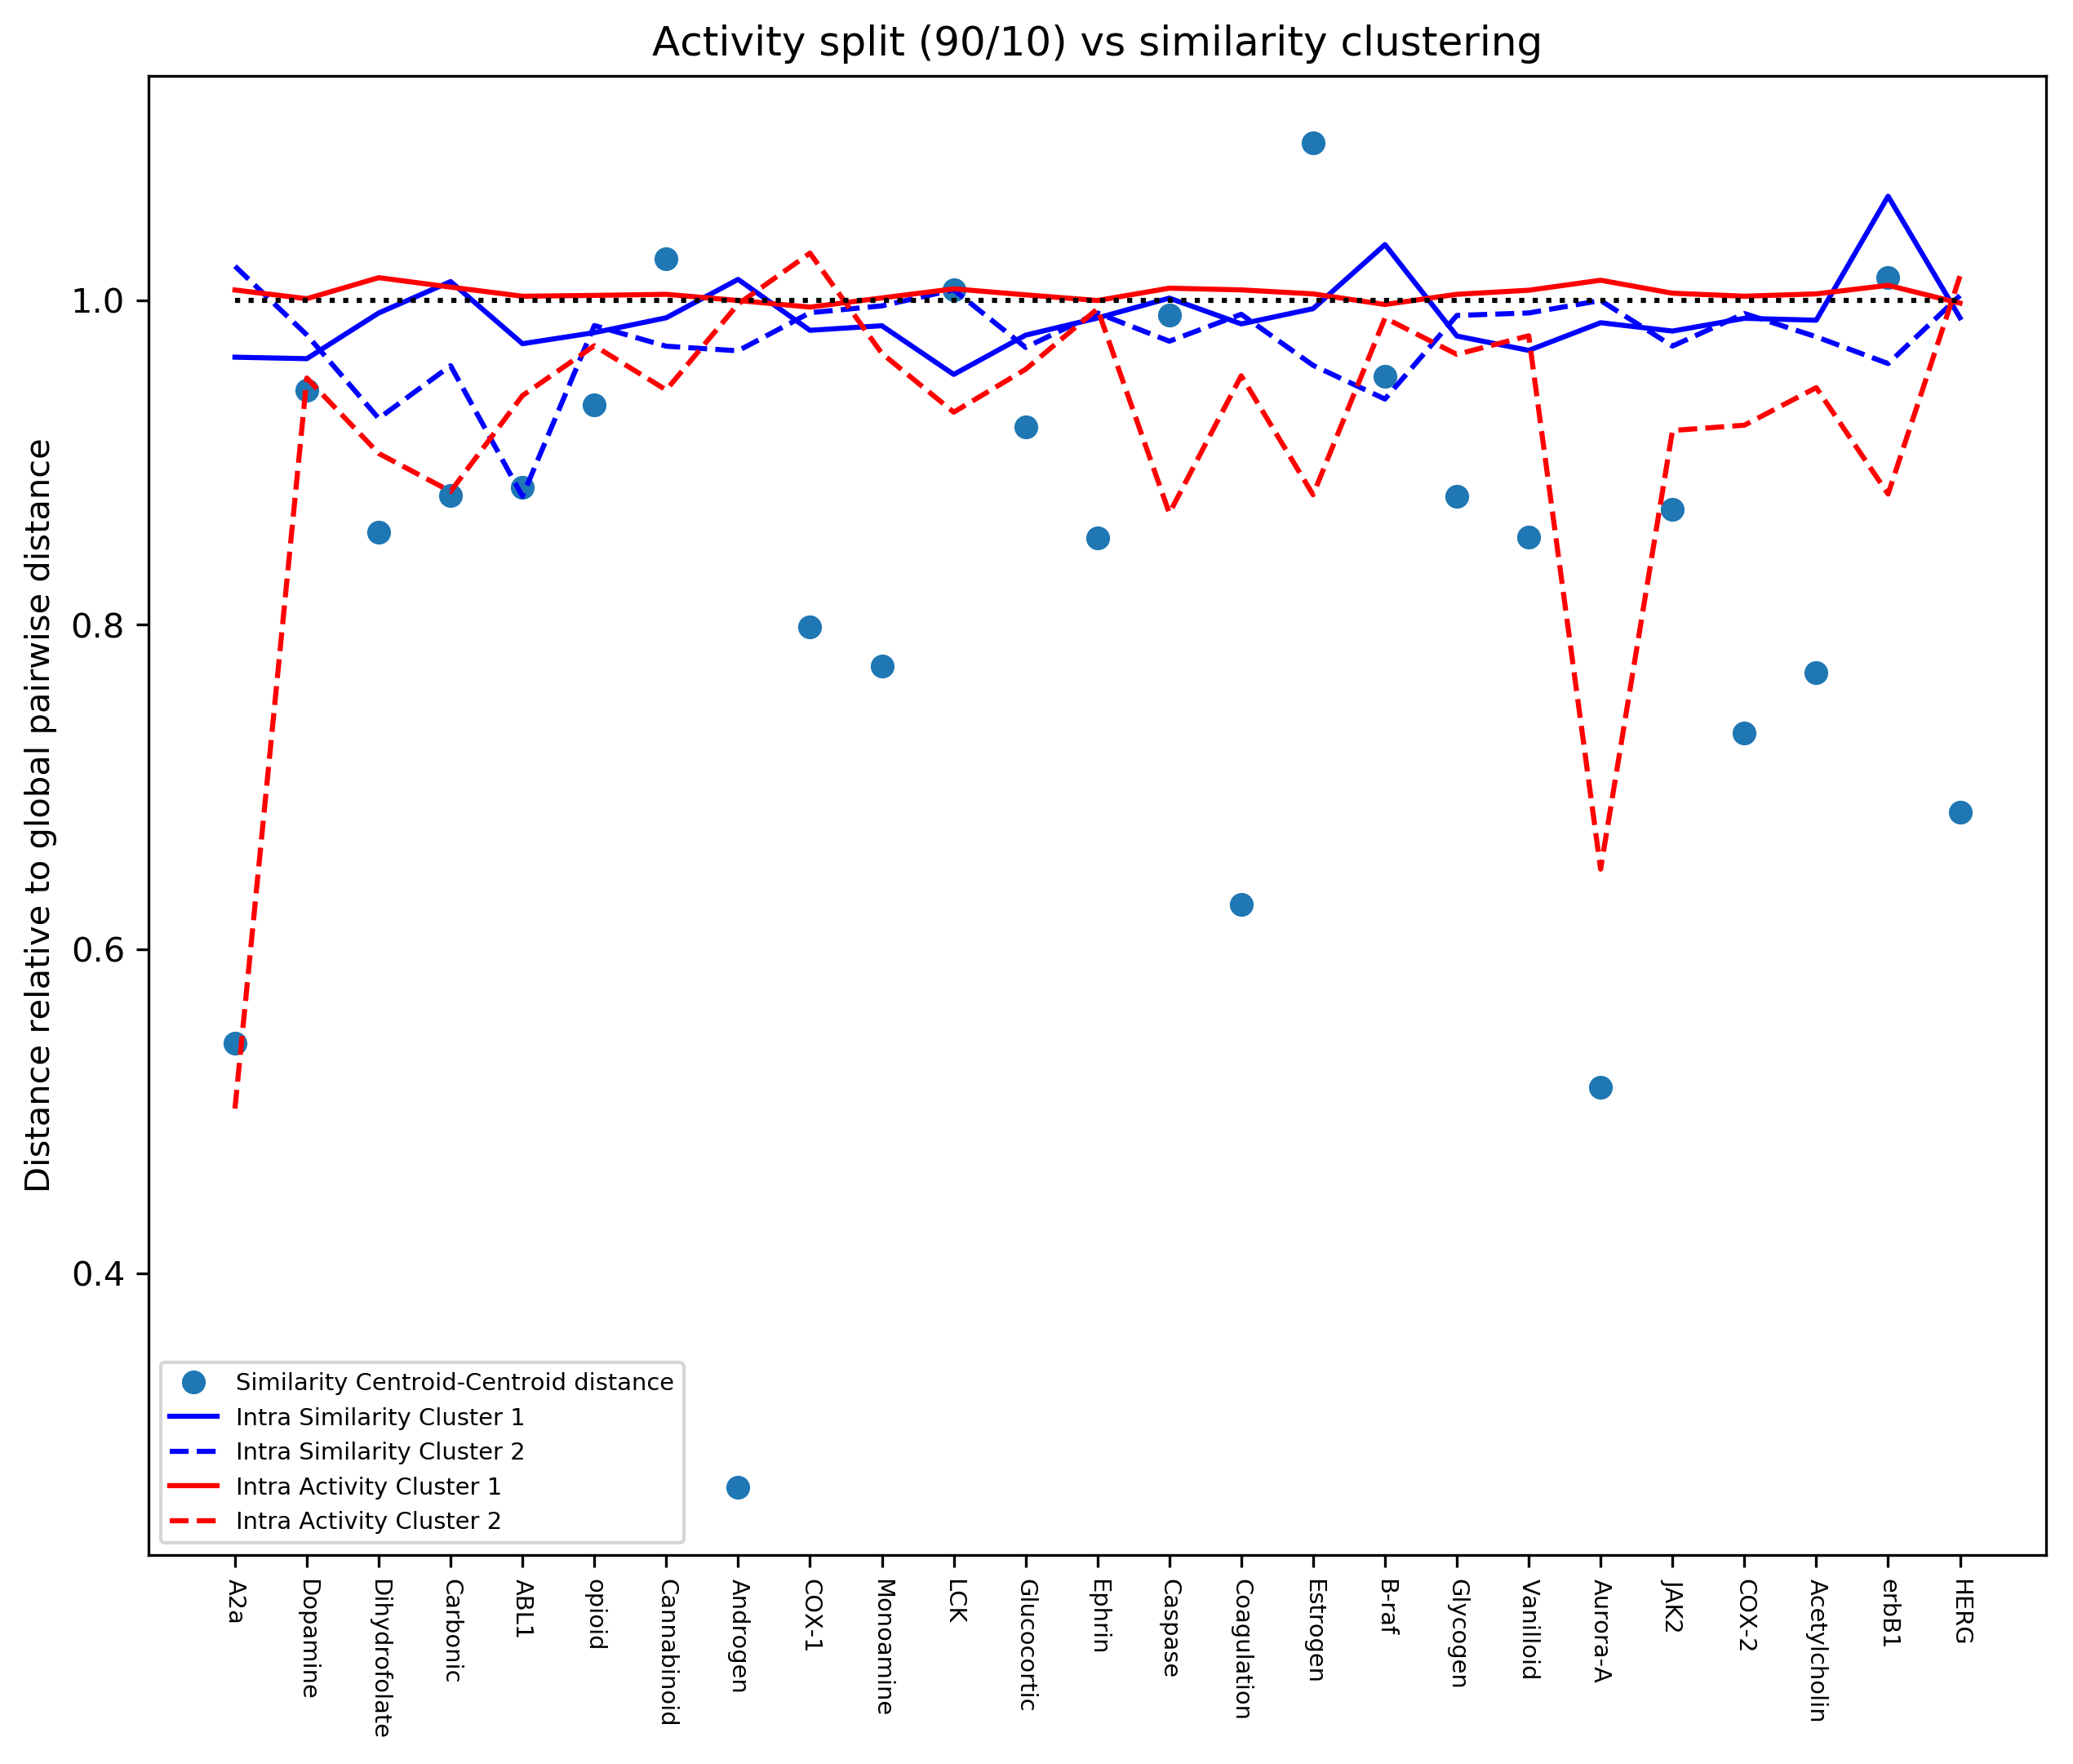

In [19]:
figure(num=None, figsize=(10, 8), dpi=300, facecolor='w', edgecolor='k')
plt.plot(np.arange(25), results['CentroidCentroid'],'o', label = 'Similarity Centroid-Centroid distance')
plt.plot(np.arange(25), results['SimCluster1_within'],'b-', label = 'Intra Similarity Cluster 1')
plt.plot(np.arange(25), results['SimCluster2_within'],'b--', label = 'Intra Similarity Cluster 2')
plt.plot(np.arange(25), results['ActivityCluster1_within'],'r-', label = 'Intra Activity Cluster 1')
plt.plot(np.arange(25), results['ActivityCluster2_within'],'r--', label = 'Intra Activity Cluster 2')
plt.ylabel('Distance relative to global pairwise distance')
plt.legend(fontsize = 'x-small')
plt.tick_params(top=False, right=False)
plt.xticks(np.arange(25), sorted_targets, rotation=-90, fontsize = 'x-small')
plt.plot(np.arange(25), np.ones(25), 'k:')
plt.title('Activity split (90/10) vs similarity clustering')
path = 'figures/'+ 'Activity_vs_Similarity' + '.png'
plt.savefig(path, dpi=400)

In [20]:
import os.path
import re

# Arguments for overall number of runs
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

def avg_mse(predictions, responses, **kwargs):
    return mean_squared_error(responses, predictions) / mean_squared_error(responses, np.zeros_like(responses))


def Rank_loss(predictions, responses, **kwargs):
    
    tgt_val = kwargs.get('tgt_val')
    ranked = np.argsort(-predictions)
    found = responses[ranked] >= tgt_val
    # Number of actives
    N_gamma = np.sum(found)
    
    # Size of test sets
    N_test = predictions.shape[0]
    lt = kwargs.get('loss_type')
    #pdb.set_trace()
    if lt == 'min':
        # Equation (1) of the paper
        loss = 1/(N_test - N_gamma) * np.min(np.arange(N_test)[found])
    elif lt == 'avg':
        # Equation (2) of the paper
        loss = 1/N_gamma * 1/(N_test - N_gamma) * (np.sum(np.arange(N_test)[found]) - N_gamma * (N_gamma - 1)/2)
        pass
    
    assert loss >= 0
    assert loss <= 1
    return loss


def Active_rank_loss_avg(predictions, responses, **kwargs):
    kwargs.update({'loss_type' :'avg'})
    return Rank_loss(predictions, responses, **kwargs)

def Active_rank_loss_min(predictions, responses, **kwargs):
    kwargs.update({'loss_type' :'min'})
    return Rank_loss(predictions, responses, **kwargs)



tot_num_runs = 400
outdir = 'models_final_dl/'
fig_dir = 'figures_dl/'
    
# define the dictionary of losses used here
loss_dict = {'mse' :       {'func' : avg_mse,         'kw' : {}},
             'loss_min_90' :   {'func' : Active_rank_loss_min,  'kw' : {'frac_find' : 0.9}},
             'loss_avg_90' :   {'func' : Active_rank_loss_avg,  'kw' : {'frac_find' : 0.9}},
             'loss_min_95' :   {'func' : Active_rank_loss_min,  'kw' : {'frac_find' : 0.95}},
             'loss_avg_95' :   {'func' : Active_rank_loss_avg,  'kw' : {'frac_find' : 0.95}},
             'loss_min_99' :   {'func' : Active_rank_loss_min,  'kw' : {'frac_find' : 0.99}},
             'loss_avg_99' :   {'func' : Active_rank_loss_avg,  'kw' : {'frac_find' : 0.99}},
            }

In [21]:
def get_fn(frac_fit, kf=0, insample=False, fig=False, loss=None):
    fn = 'loss_' + str(frac_fit)
    if kf > 0:
        fn += '_kf_' + str(kf)
        pass
    if insample:
        fn += '_insample'
        pass
    od = fig_dir if fig else outdir
    ffn = os.path.join(od, fn)
    if fig:
        ffn = re.sub('[.]','', ffn)
        ffn = ffn + '_' + loss + '.pdf'
        pass
    return ffn
        

    
# Plots results
# Added put_title arg for plots for paper
def plot_loss_vs_similarity(similarity_Cluster2, frac_fit=1.0, kf=0,  loss='mse', save=True, 
                            put_title=False, put_grid=False):
    
    insample=False
    fnf = get_fn(frac_fit, kf=kf, insample=insample)
    
    loss_hdr = joblib.load(fnf)
    model_labels = []
    
    for (i, method) in enumerate(model_dict.keys()):
        model_labels.append(model_dict[method]['label'])
        losses = []
        for x in sorted_targets:
            try:
                losses.append(loss_hdr[x][method][loss]['loss'])
            except:
                print(x, method, loss)
                raise KeyError
        losses = np.asarray(losses)
        plt.plot(similarity_Cluster2, losses, 'o', label = method)
        
        pass
        
    
    ttl = 'OOS %s Loss' % loss.upper()
    if kf > 0:
        ttl += ' with %d fold CV' % kf
    if frac_fit < 1.0:
        ttl += ' Max activity in fit at %.1f' % frac_fit
    if put_title:
        title(ttl)
   
    plt.legend()

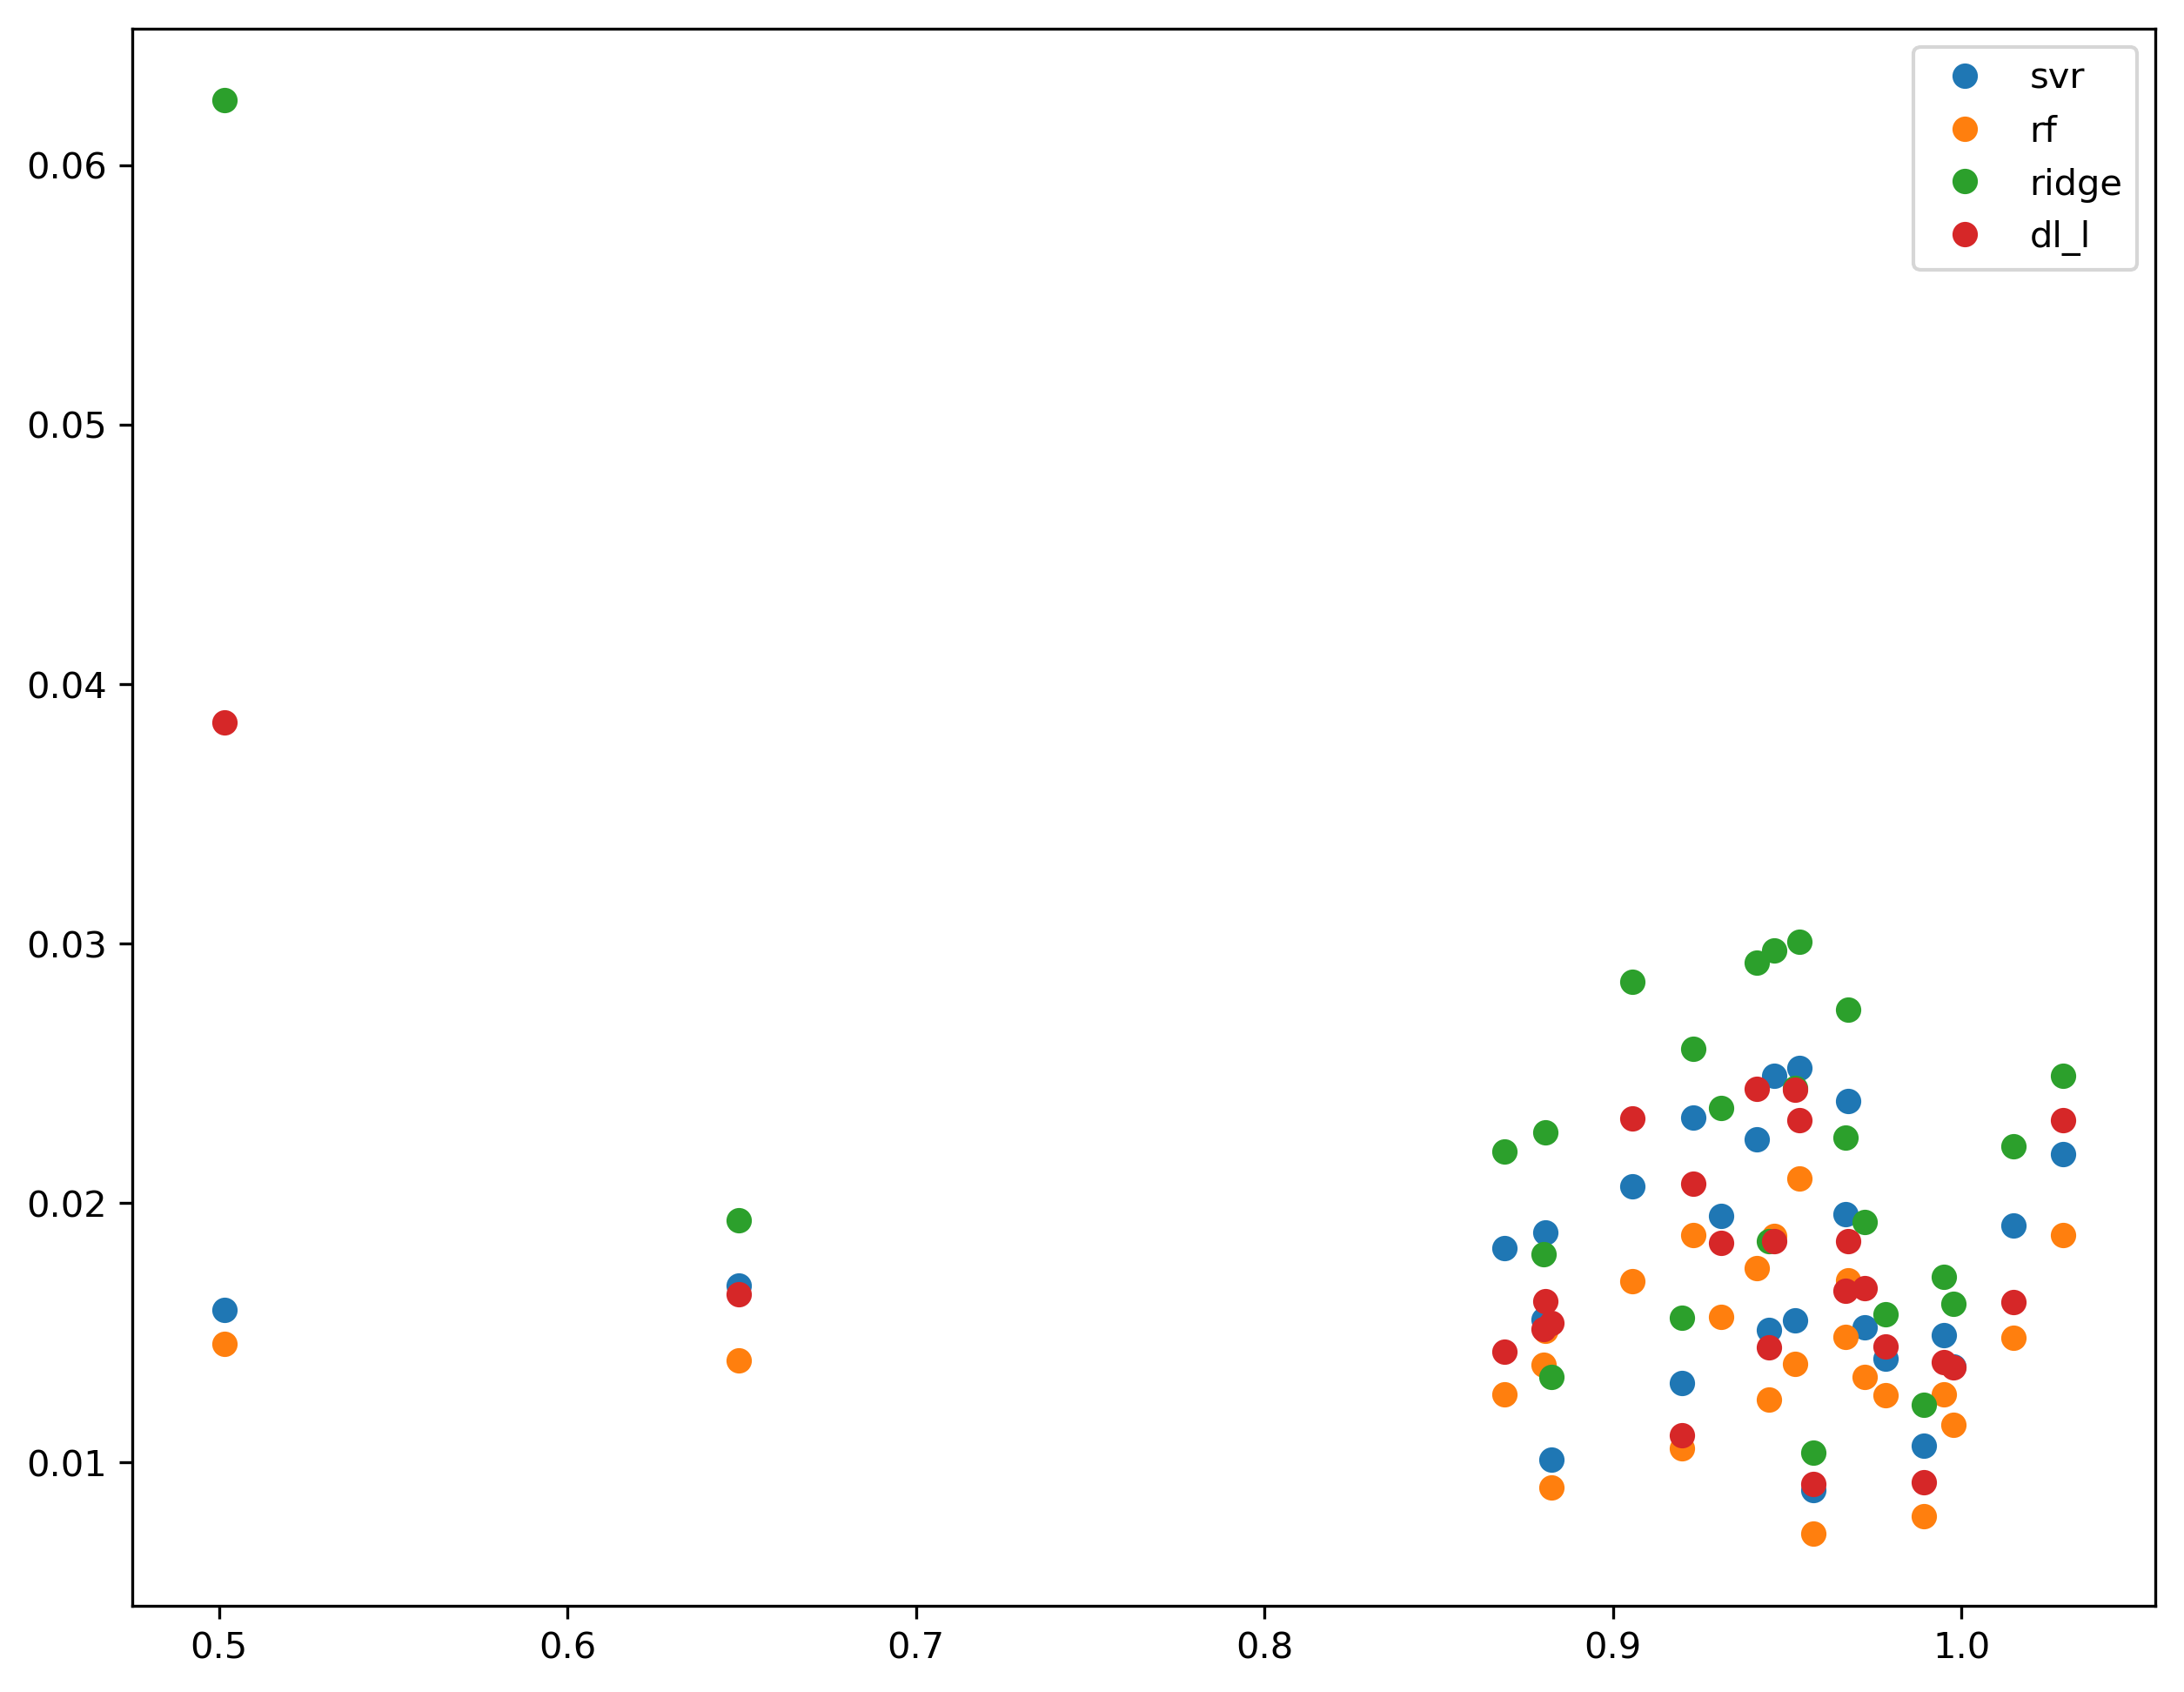

In [22]:
figure(num=None, figsize=(10, 8), dpi=300, facecolor='w', edgecolor='k')
plot_loss_vs_similarity(results['ActivityCluster2_within'])
